In [ ]:
!pip install tensorflow==2.0.0b1

import tensorflow as tf
print(tf.__version__)

import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(
    (
      tf.cast(series, tf.float32)
    )
  )
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

     |████████████████████████████████| 87.9MB 46kB/s 
     |████████████████████████████████| 501kB 42.2MB/s 
     |████████████████████████████████| 3.1MB 55.2MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

2.0.0-beta1
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


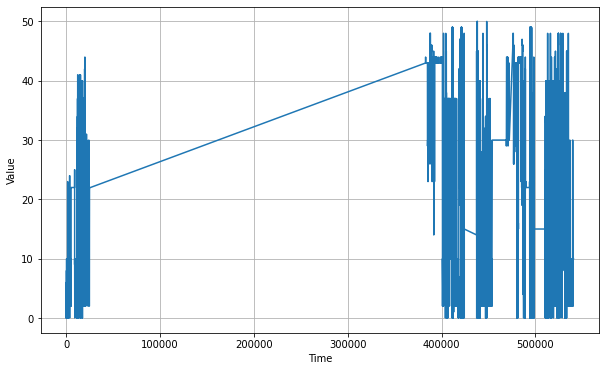

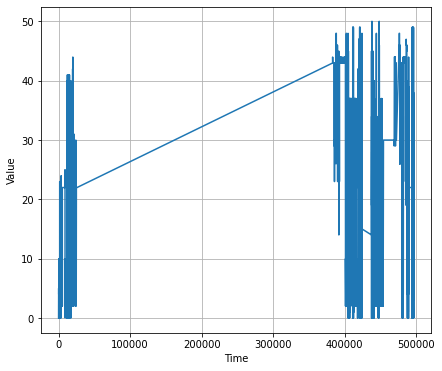

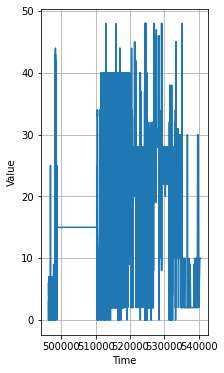

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
window_size = 10
path = "/content/drive/My Drive/Colab Notebooks/data/casas-event6.csv"


batch_size = 32
shuffle_buffer_size = 1000

df = pd.read_csv(path)

#print(df.head)
# Dataset is now stored in a Pandas Dataframe

series = pd.Series(df['event'], index=df.index)
time = pd.Series(df['time'], index=df.index)

df

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()





split_time = int(len(df)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(7, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(3, 6))
plot_series(time_valid, x_valid)
plt.show()




tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=5,verbose=0)

model.summary()

11.606847
2.225862
1.4919323


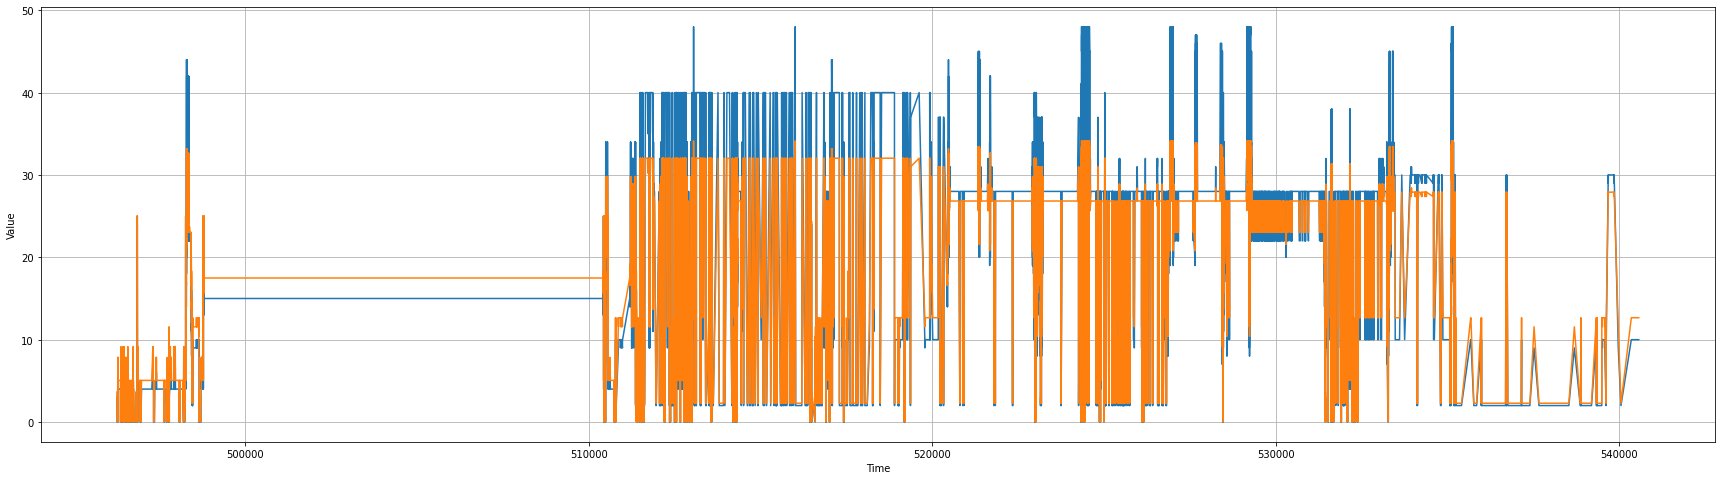

In [ ]:
forecast = []
results = []
for timing in range(len(series) - window_size):
  prediction = model.predict(series[timing + window_size][np.newaxis]) * (5) #3, 2.8
  prediction = prediction - (6.5) #2, 5.5
  #print(prediction)
  forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(30, 8))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(np.sqrt(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

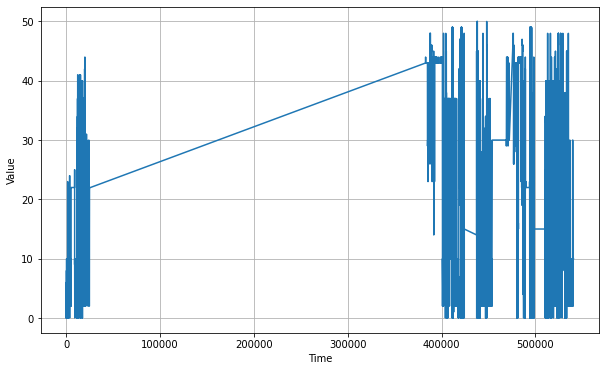

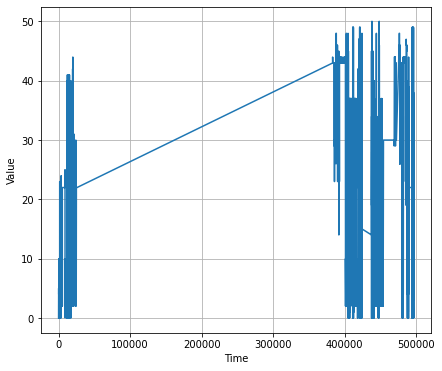

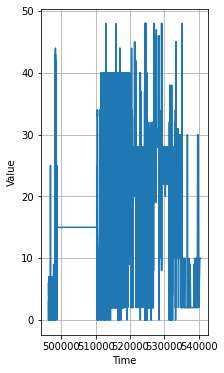

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
169.84064
11.047966
3.323848


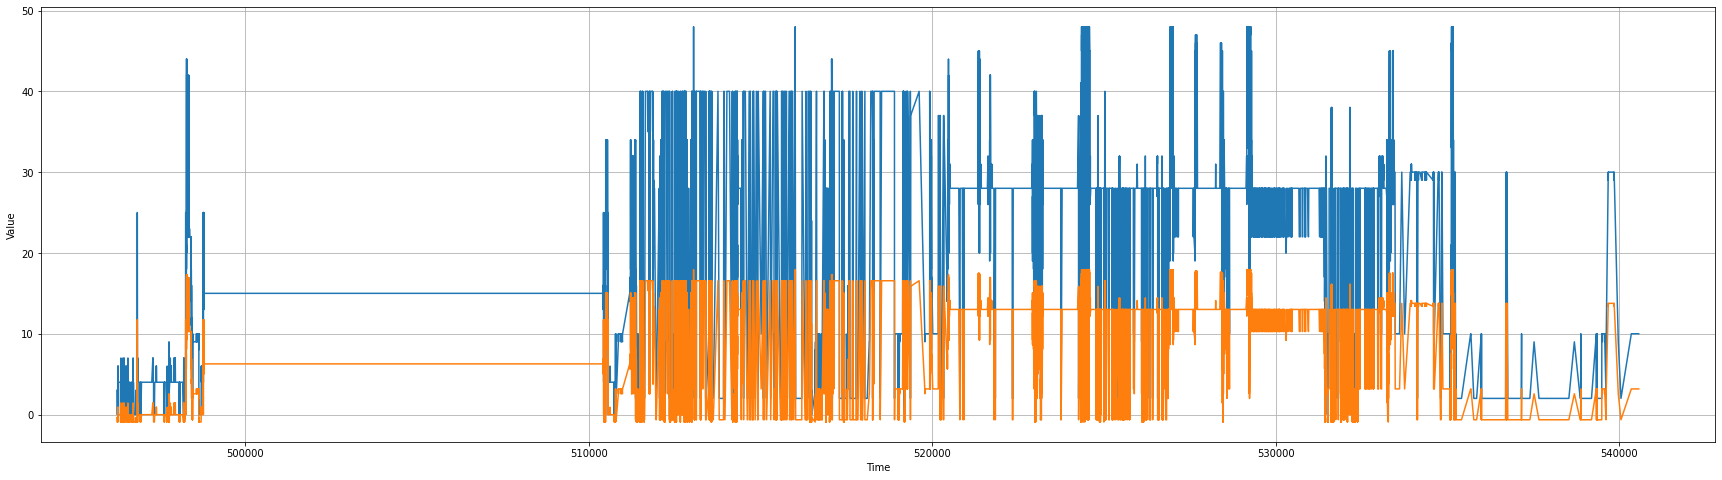

In [ ]:
window_size = 100


batch_size = 32
shuffle_buffer_size = 1000

df = pd.read_csv(path)

#print(df.head)
# Dataset is now stored in a Pandas Dataframe

series = pd.Series(df['event'], index=df.index)
time = pd.Series(df['time'], index=df.index)

df

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()





split_time = int(len(df)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(7, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(3, 6))
plot_series(time_valid, x_valid)
plt.show()




tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=5,verbose=0)

model.summary()

forecast = []
results = []
for timing in range(len(series) - window_size):
  prediction = model.predict(series[timing + window_size][np.newaxis]) * (3.5) #3, 2.8
  prediction = prediction - (4.5) #2, 5.5
  #print(prediction)
  forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(30, 8))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(np.sqrt(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

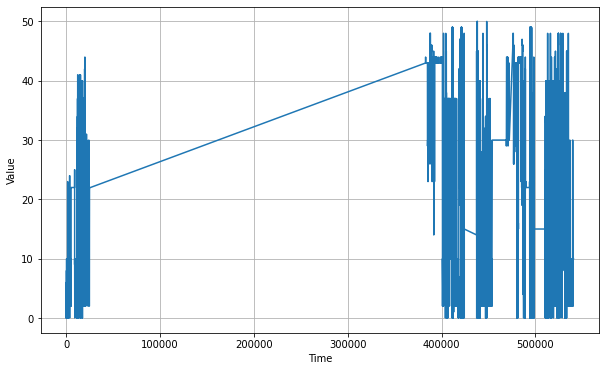

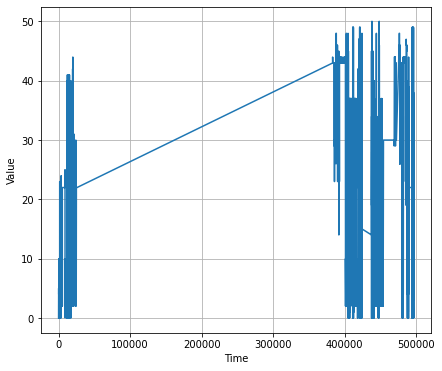

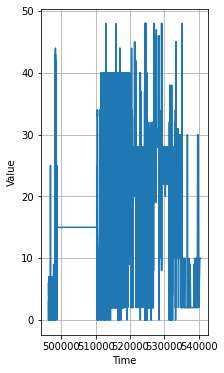

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
130.09636
8.97729
2.9962127


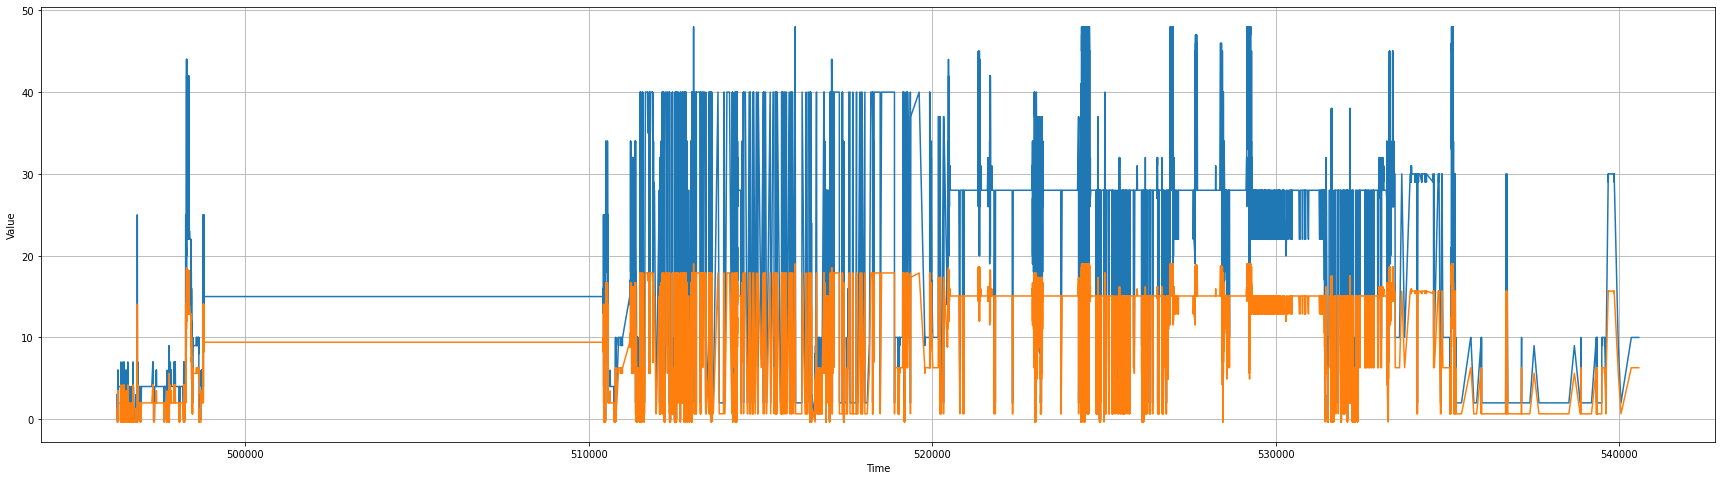

In [ ]:
window_size = 20


batch_size = 32
shuffle_buffer_size = 1000

df = pd.read_csv(path)

#print(df.head)
# Dataset is now stored in a Pandas Dataframe

series = pd.Series(df['event'], index=df.index)
time = pd.Series(df['time'], index=df.index)

df

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()





split_time = int(len(df)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(7, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(3, 6))
plot_series(time_valid, x_valid)
plt.show()




tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=5,verbose=0)

model.summary()

forecast = []
results = []
for timing in range(len(series) - window_size):
  prediction = model.predict(series[timing + window_size][np.newaxis]) * (3.5) #3, 2.8
  prediction = prediction - (4.5) #2, 5.5
  #print(prediction)
  forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(30, 8))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(np.sqrt(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

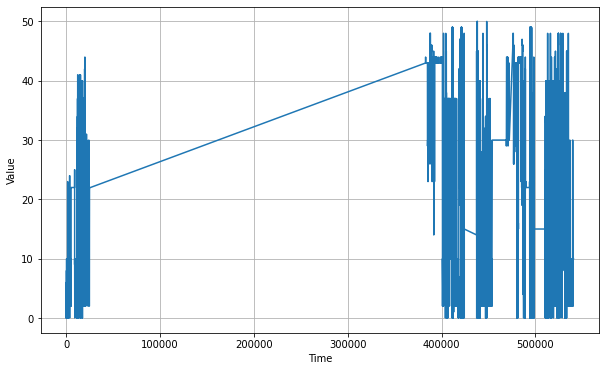

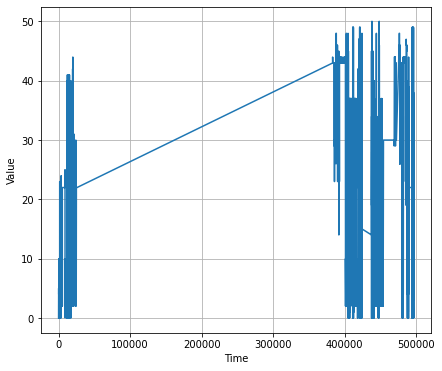

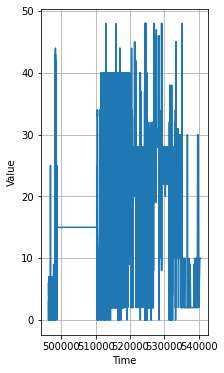

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
75.35541
6.7710037
2.6021152


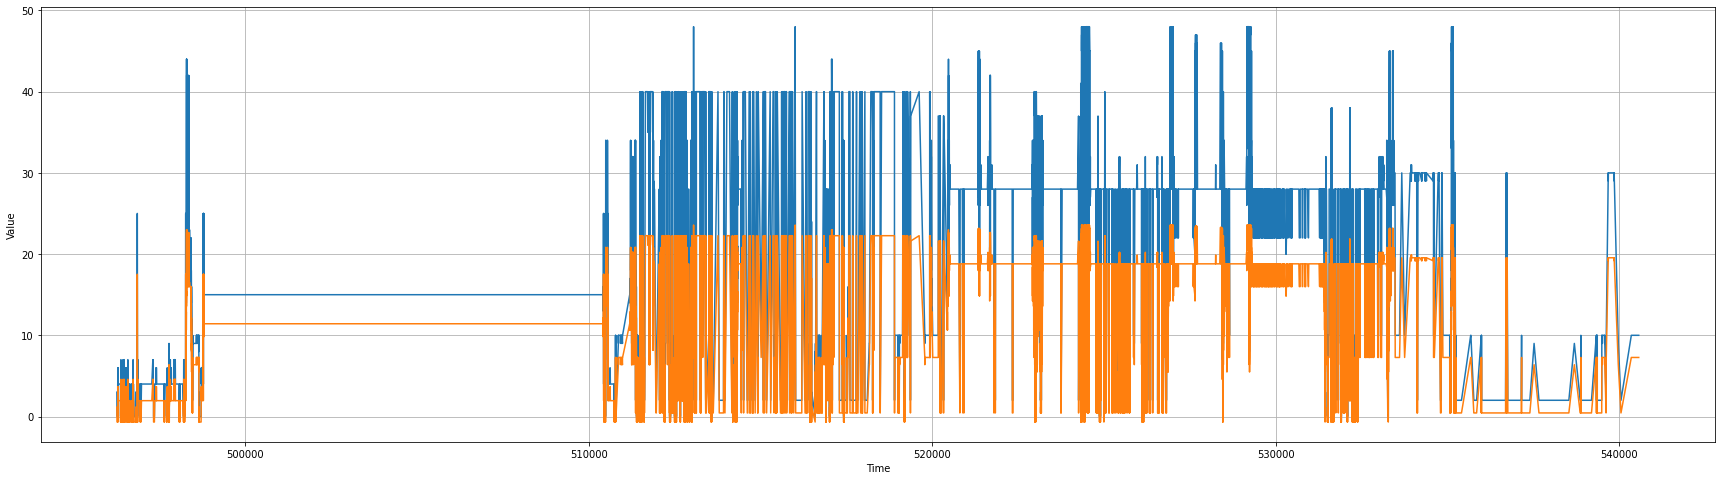

In [ ]:
window_size = 30


batch_size = 32
shuffle_buffer_size = 1000

df = pd.read_csv(path)

#print(df.head)
# Dataset is now stored in a Pandas Dataframe

series = pd.Series(df['event'], index=df.index)
time = pd.Series(df['time'], index=df.index)

df

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()





split_time = int(len(df)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(7, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(3, 6))
plot_series(time_valid, x_valid)
plt.show()




tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=5,verbose=0)

model.summary()

forecast = []
results = []
for timing in range(len(series) - window_size):
  prediction = model.predict(series[timing + window_size][np.newaxis]) * (3.5) #3, 2.8
  prediction = prediction - (4.5) #2, 5.5
  #print(prediction)
  forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(30, 8))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(np.sqrt(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

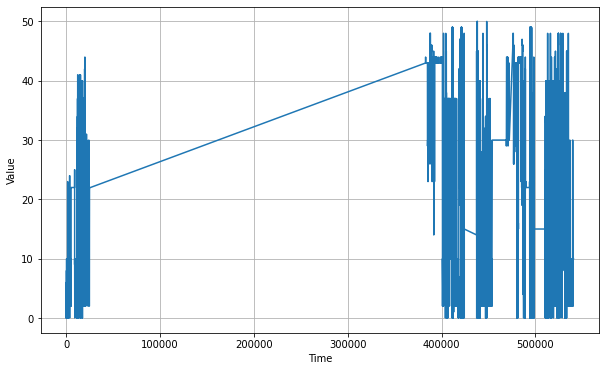

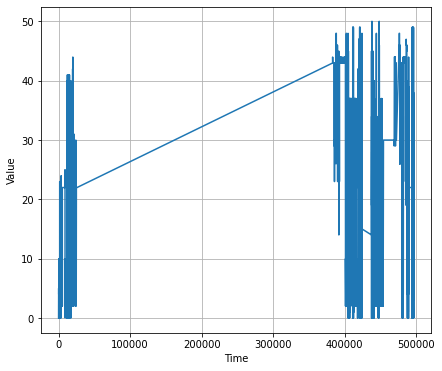

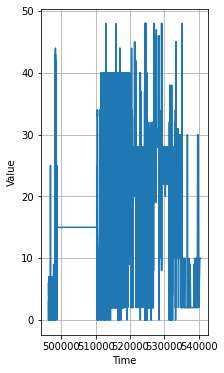

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
94.65738
7.73537
2.7812533


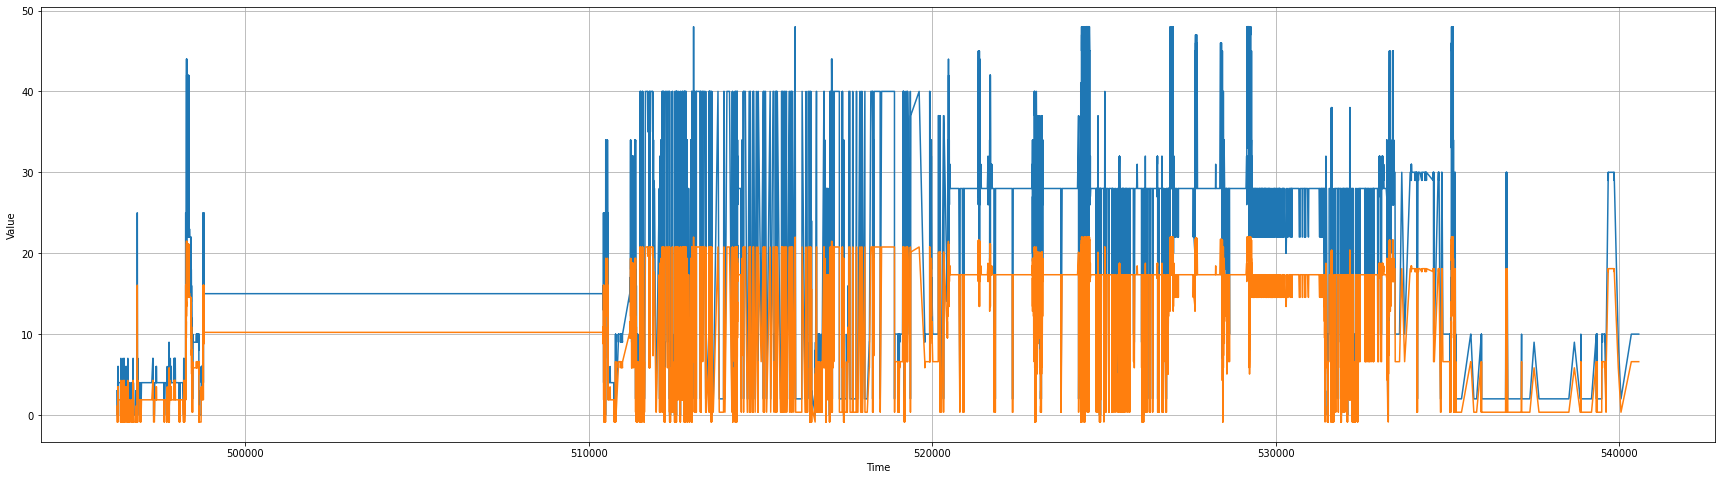

In [ ]:
window_size = 40


batch_size = 32
shuffle_buffer_size = 1000

df = pd.read_csv(path)

#print(df.head)
# Dataset is now stored in a Pandas Dataframe

series = pd.Series(df['event'], index=df.index)
time = pd.Series(df['time'], index=df.index)

df

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()





split_time = int(len(df)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(7, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(3, 6))
plot_series(time_valid, x_valid)
plt.show()




tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=5,verbose=0)

model.summary()

forecast = []
results = []
for timing in range(len(series) - window_size):
  prediction = model.predict(series[timing + window_size][np.newaxis]) * (3.5) #3, 2.8
  prediction = prediction - (4.5) #2, 5.5
  #print(prediction)
  forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(30, 8))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(np.sqrt(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

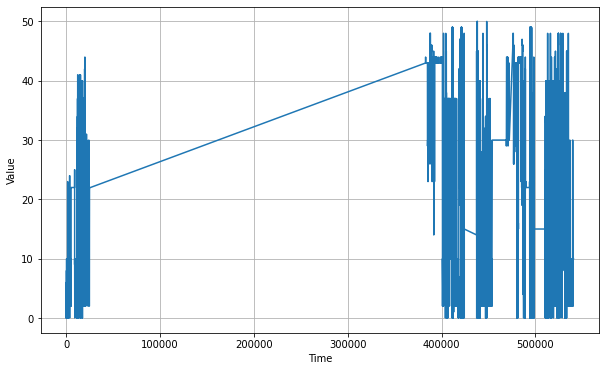

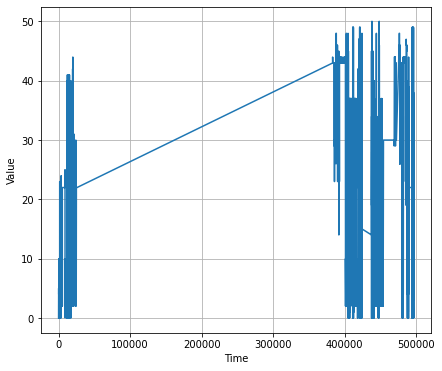

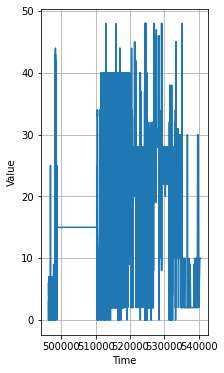

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
120.59122
9.19798
3.0328171


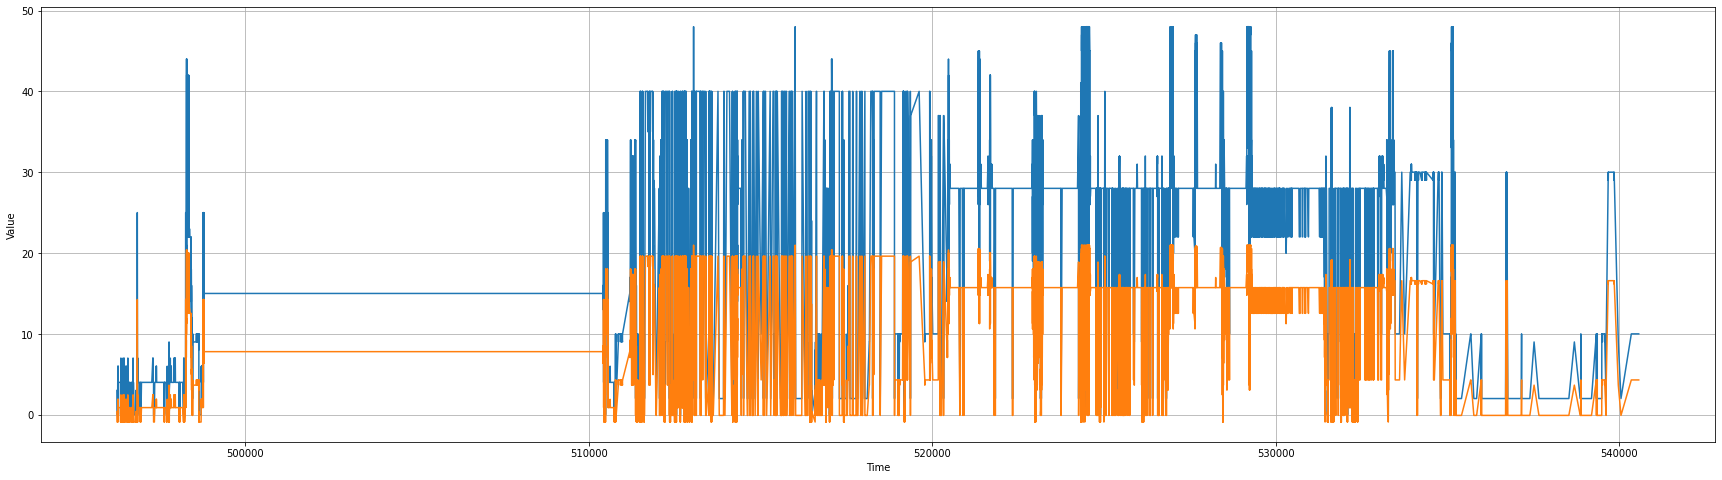

In [ ]:
window_size = 50


batch_size = 32
shuffle_buffer_size = 1000

df = pd.read_csv(path)

#print(df.head)
# Dataset is now stored in a Pandas Dataframe

series = pd.Series(df['event'], index=df.index)
time = pd.Series(df['time'], index=df.index)

df

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()





split_time = int(len(df)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(7, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(3, 6))
plot_series(time_valid, x_valid)
plt.show()




tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=5,verbose=0)

model.summary()

forecast = []
results = []
for timing in range(len(series) - window_size):
  prediction = model.predict(series[timing + window_size][np.newaxis]) * (3.5) #3, 2.8
  prediction = prediction - (4.5) #2, 5.5
  #print(prediction)
  forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(30, 8))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(np.sqrt(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

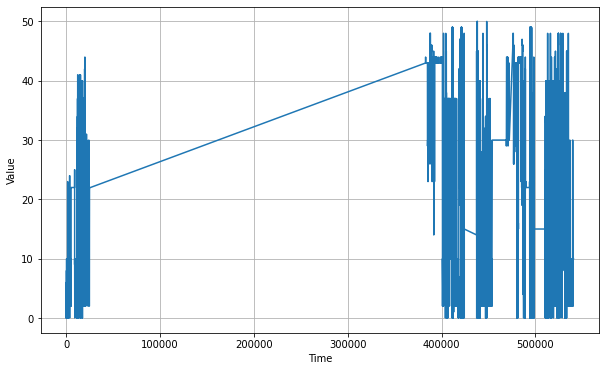

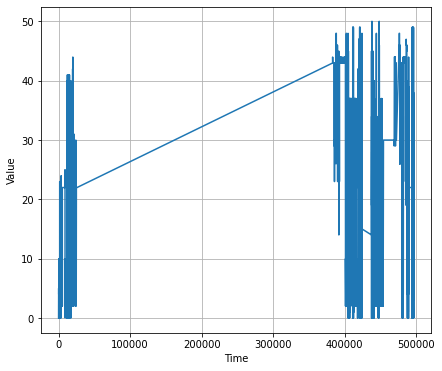

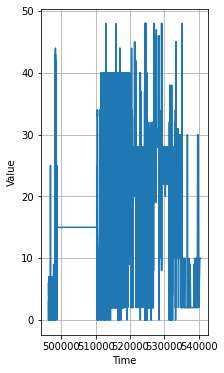

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
92.274445
7.795174
2.7919838


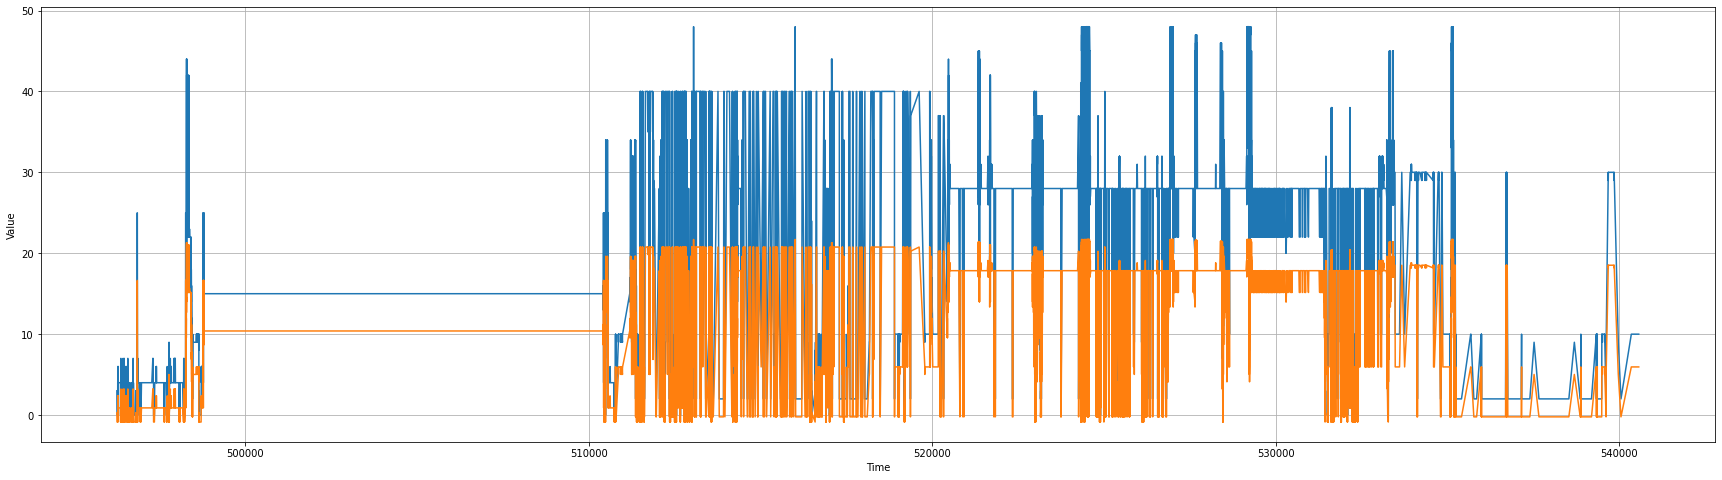

In [ ]:
window_size = 60


batch_size = 32
shuffle_buffer_size = 1000

df = pd.read_csv(path)

#print(df.head)
# Dataset is now stored in a Pandas Dataframe

series = pd.Series(df['event'], index=df.index)
time = pd.Series(df['time'], index=df.index)

df

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()





split_time = int(len(df)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(7, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(3, 6))
plot_series(time_valid, x_valid)
plt.show()




tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=5,verbose=0)

model.summary()

forecast = []
results = []
for timing in range(len(series) - window_size):
  prediction = model.predict(series[timing + window_size][np.newaxis]) * (3.5) #3, 2.8
  prediction = prediction - (4.5) #2, 5.5
  #print(prediction)
  forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(30, 8))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(np.sqrt(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

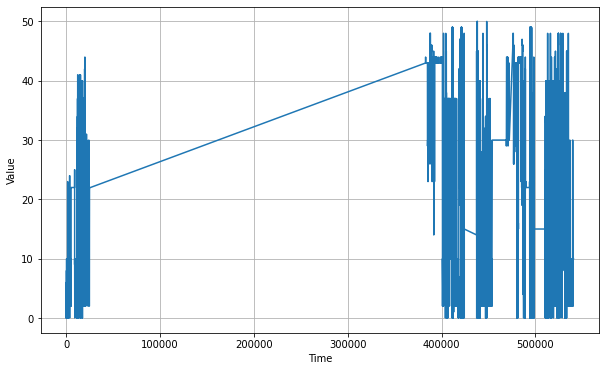

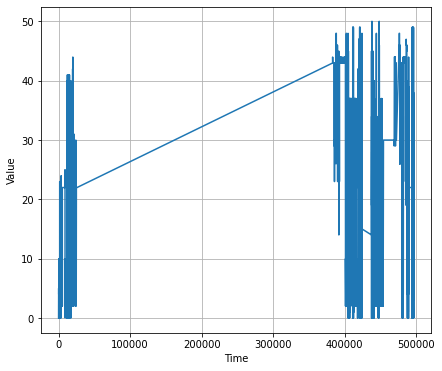

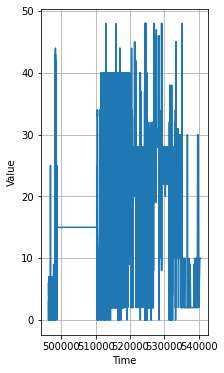

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
60.466484
5.8871527
2.4263456


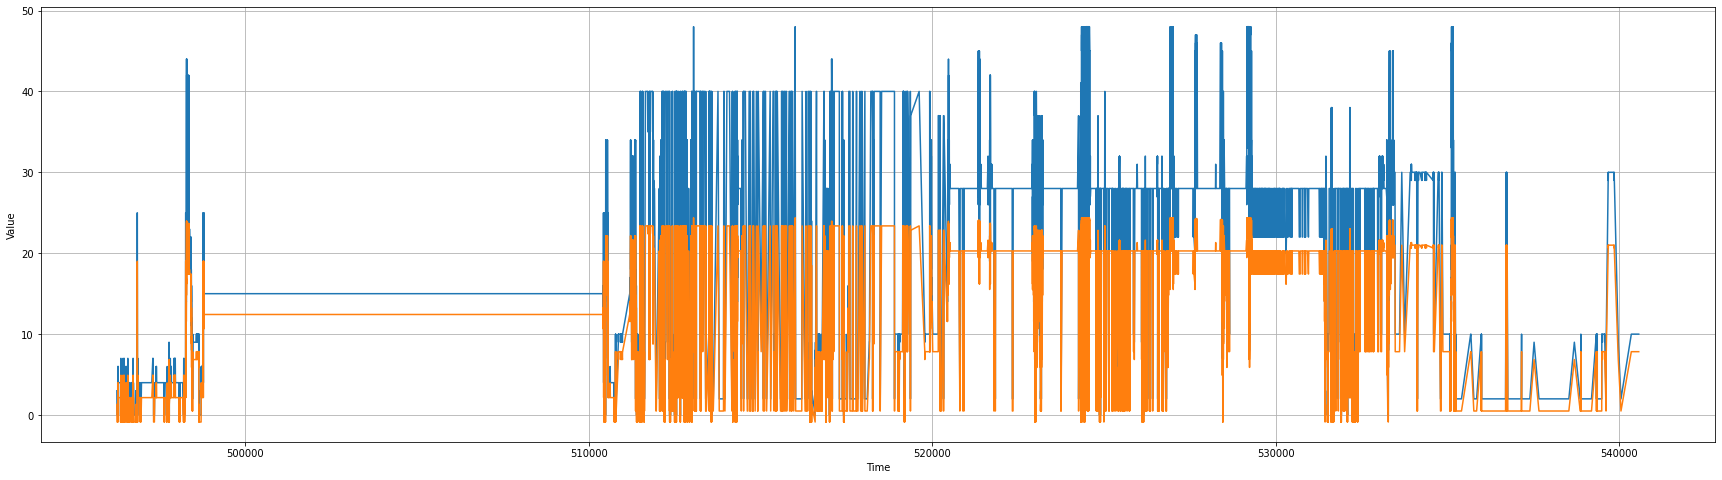

In [ ]:
window_size = 70


batch_size = 32
shuffle_buffer_size = 1000

df = pd.read_csv(path)

#print(df.head)
# Dataset is now stored in a Pandas Dataframe

series = pd.Series(df['event'], index=df.index)
time = pd.Series(df['time'], index=df.index)

df

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()





split_time = int(len(df)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(7, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(3, 6))
plot_series(time_valid, x_valid)
plt.show()




tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=5,verbose=0)

model.summary()

forecast = []
results = []
for timing in range(len(series) - window_size):
  prediction = model.predict(series[timing + window_size][np.newaxis]) * (3.5) #3, 2.8
  prediction = prediction - (4.5) #2, 5.5
  #print(prediction)
  forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(30, 8))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(np.sqrt(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

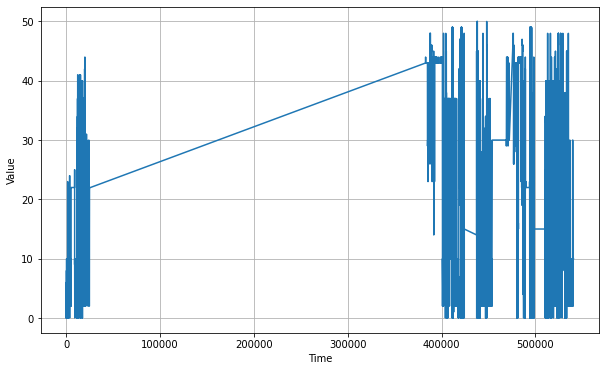

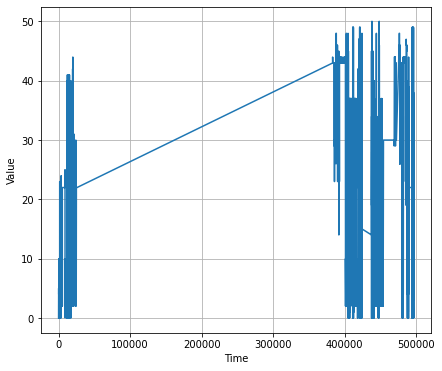

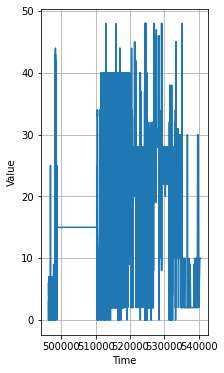

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
118.1407
9.059279
3.0098636


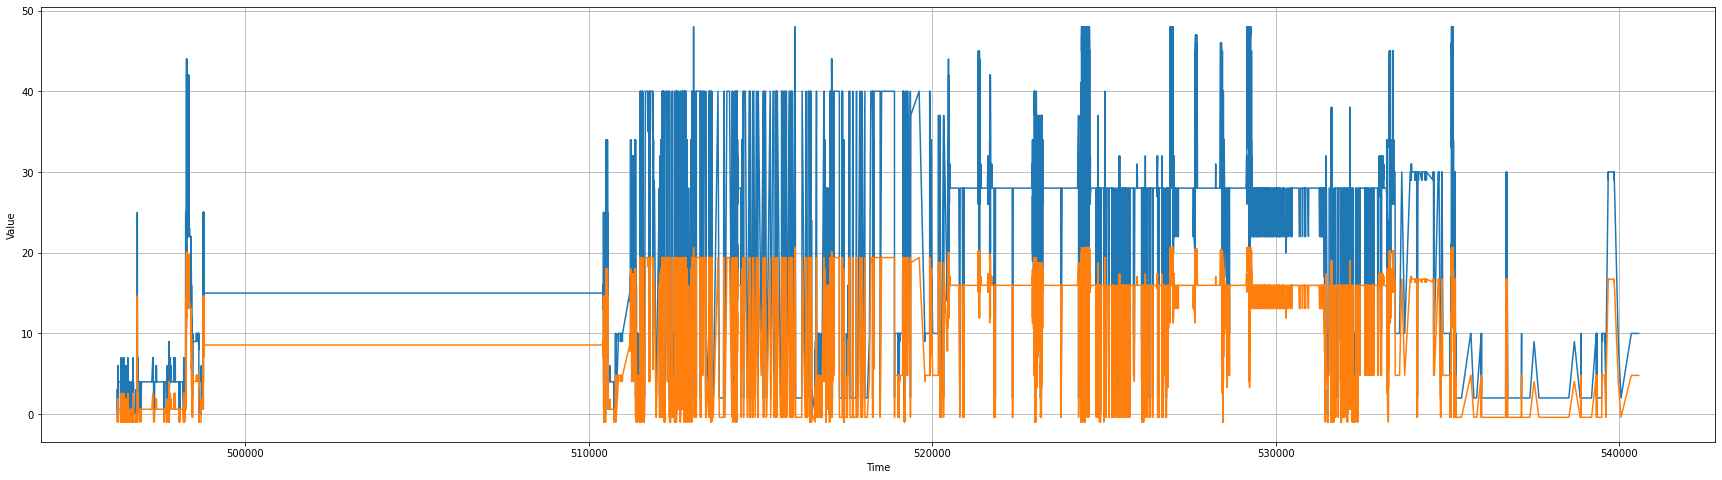

In [ ]:
window_size = 80


batch_size = 32
shuffle_buffer_size = 1000

df = pd.read_csv(path)

#print(df.head)
# Dataset is now stored in a Pandas Dataframe

series = pd.Series(df['event'], index=df.index)
time = pd.Series(df['time'], index=df.index)

df

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()





split_time = int(len(df)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(7, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(3, 6))
plot_series(time_valid, x_valid)
plt.show()




tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=5,verbose=0)

model.summary()

forecast = []
results = []
for timing in range(len(series) - window_size):
  prediction = model.predict(series[timing + window_size][np.newaxis]) * (3.5) #3, 2.8
  prediction = prediction - (4.5) #2, 5.5
  #print(prediction)
  forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(30, 8))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(np.sqrt(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))

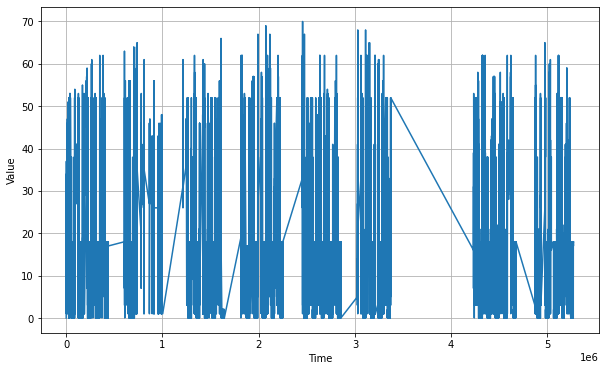

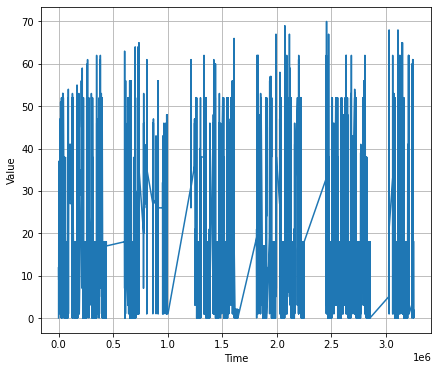

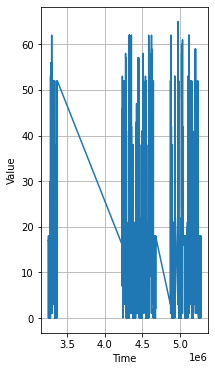

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
85.26319
7.696191
2.774201


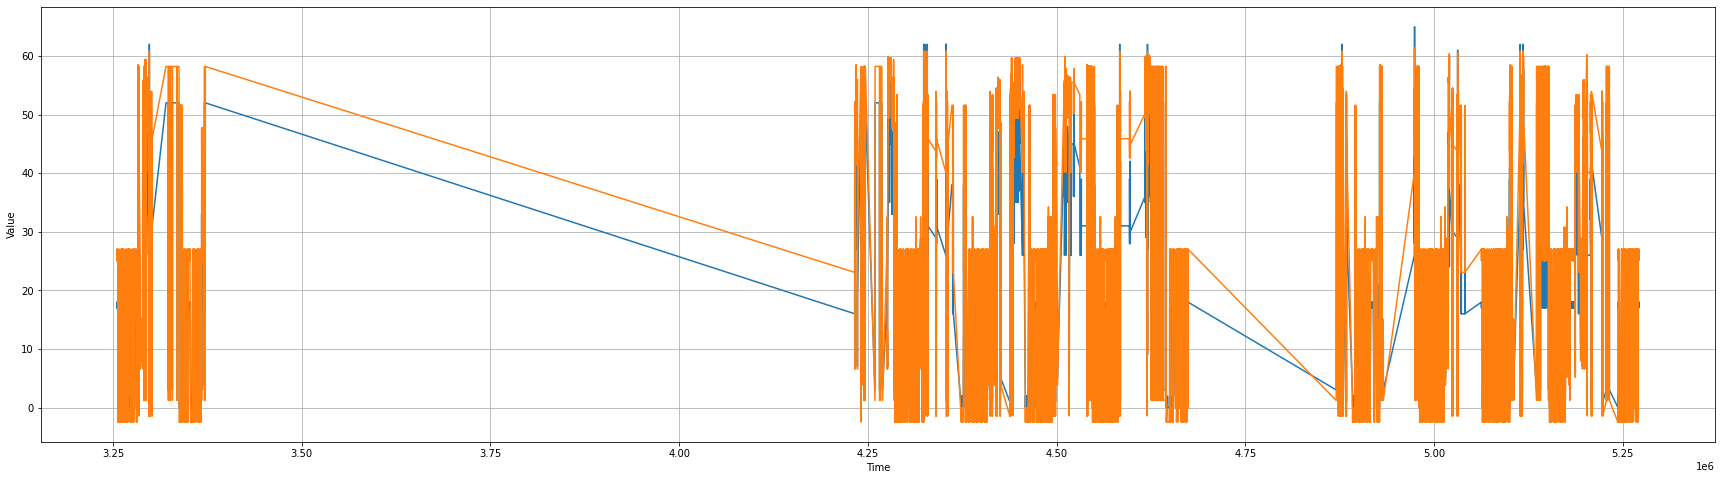

In [ ]:
window_size = 90
path = "/content/drive/My Drive/Colab Notebooks/data/casas-event7.csv"


batch_size = 32
shuffle_buffer_size = 1000

df = pd.read_csv(path)

#print(df.head)
# Dataset is now stored in a Pandas Dataframe

series = pd.Series(df['event'], index=df.index)
time = pd.Series(df['time'], index=df.index)

df

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()





split_time = int(len(df)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(7, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(3, 6))
plot_series(time_valid, x_valid)
plt.show()




tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=5,verbose=0)

model.summary()

forecast = []
results = []
for timing in range(len(series) - window_size):
  prediction = model.predict(series[timing + window_size][np.newaxis]) * (3.5) #3, 2.8
  prediction = prediction - (4.5) #2, 5.5
  #print(prediction)
  forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(30, 8))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(np.sqrt(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()))